Reward is distance between action and trained layer after 10 gradient steps.

Imp'l details
- copy layers to run backprop
- run on 3, 4, and then 5 layer networks for the 3rd, 4th, and 5th layers

Next steps
- if it learns how to output layers with that loss/reward, can consider unbounded design

In [1]:
import math
import random
import datetime
from collections import defaultdict
from enum import Enum
import numpy as np 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gymnasium
from typing import (
    Type,
    List,
    Tuple,
)
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO, A2C
import wandb

- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

## config

In [2]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'pretrain' : False,
    'episodic' : False,
    'epochs' : 1,
    'timesteps' : 5000,
    'n_x' : 100,
    'n_tasks' : 2,
    'in_features' : 1,
    'out_features' : 1,
    'n_pool_hidden_layers' : 10,
    'n_hidden_layers_per_network' : 1,
    'n_layers_per_network' : 3,
    'n_nodes_per_layer' : 40,
    'pool_layer_type' : torch.nn.Linear,
    'batch_size' : 100,
    'learning_rate' : 0.05,
    'action_cache_size' : 5,
    'num_workers' : 0,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'A2C',
    'sb3_policy' : 'MlpPolicy',
    'log_dir' : 'wandb',
    }
config = default_config
config['n_pool_hidden_layers'] = config['n_tasks'] * config['n_hidden_layers_per_network']
config

{'seed': 41,
 'device': 'cuda',
 'pretrain': False,
 'episodic': False,
 'epochs': 1,
 'timesteps': 5000,
 'n_x': 100,
 'n_tasks': 2,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 2,
 'n_hidden_layers_per_network': 1,
 'n_layers_per_network': 3,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 100,
 'learning_rate': 0.05,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'A2C',
 'sb3_policy': 'MlpPolicy',
 'log_dir': 'wandb'}

In [3]:
wandb.init(
    project='reinforcement-meta-learning',
    config=config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mattstachyra. Use `wandb login --relogin` to force relogin


In [4]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Decision Process"

### sinusoidal curve regression as in MAML 2018 paper

In [5]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        {'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


In [6]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([2, 100])
torch.float32
torch.Size([2, 100])
torch.float32
2
8


In [7]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as n_x.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data}, targets={self.targets}, info={self.info})'

In [8]:
def get_params_and_gradients(layers):
    num_layers = len(layers)
    max_num_hidden_layers = config['n_hidden_layers_per_network']
    num_hidden_layers = num_layers - 2
    hidden_layers = layers[1:-1]
    params = [layer.weight.detach() for layer in hidden_layers]
    gradients = [layer.weight.grad for layer in hidden_layers]
    if num_hidden_layers < config['n_hidden_layers_per_network']:
        zero_pad = [torch.zeros((config['n_nodes_per_layer'], config['n_nodes_per_layer']), dtype=torch.float32)] * (max_num_hidden_layers - num_hidden_layers)
        zero_pad_tensor = torch.stack(zero_pad)
        if len(params) > 0 and len(gradients) > 0:
            params = torch.stack(params)
            gradients = torch.stack(gradients)
            params = torch.cat((params, zero_pad_tensor))
            gradients = torch.cat((gradients, zero_pad_tensor)) 
        else:
            params = zero_pad_tensor
            gradients = zero_pad_tensor
    else:
        params = torch.stack(params)
        gradients = torch.stack(gradients)
    assert params.shape==(max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']), f"[ERROR] Expected params shape={max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']}, got {params.shape}"
    return params.view(-1), gradients.view(-1)

In [9]:
def get_latent_space(latent_space):
    flattened_latent_space = latent_space.view(-1)
    flattened_size = flattened_latent_space.numel()
    target_size = config['batch_size'] * config['n_nodes_per_layer']
    if flattened_size < target_size:
        num_elements_to_pad = target_size - flattened_size
        padding_tensor = torch.zeros(num_elements_to_pad)
        padded_tensor = torch.cat((flattened_latent_space, padding_tensor), dim=0)
        return padded_tensor
    else:
        return flattened_latent_space

In [39]:
class InnerNetwork(gymnasium.Env, torch.nn.Module):
    def __init__(self, 
                task: InnerNetworkTask,
                epoch: int=0,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                action_cache_size: float=config['action_cache_size'],
                num_workers: int=config['num_workers'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.task = task
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.action_cache_size = action_cache_size
        self.num_workers = num_workers
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.initial_layer = torch.nn.Linear(in_features=in_features, out_features=config['n_nodes_per_layer'])
        self.final_layer = torch.nn.Linear(in_features=config['n_nodes_per_layer'], out_features=out_features)
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
        [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.timestep = 0
        self.cum_loss = 0
        self.cum_reward = 0
        self.errors = 0
        self.rewards_per_episode = []
        self.steps_per_episode = []
        self.eval()
        self.next_batch()
        self.run_inner_network()
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = gymnasium.spaces.box.Box(low=-1, high=1, shape=(config['n_nodes_per_layer'] * config['n_nodes_per_layer'], ))

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        self.timestep += 1
        self.train()
        self.next_batch()

        new_hidden_layer = torch.nn.Linear(config['n_nodes_per_layer'], config['n_nodes_per_layer'])
        weights = torch.tensor(action).reshape(config['n_nodes_per_layer'], config['n_nodes_per_layer'])
        new_hidden_layer.weight.data = weights
        output_layer = self.layers.pop(-1) 
        self.layers.append(new_hidden_layer)
        self.layers.append(output_layer)
        if len(self.layers)==config['n_layers_per_network']:
            termination = True
        else:
            termination = False
        self.run_inner_network()
        s_prime = self.build_state()
        reward = self.reward()
        self.update_internal_trackers()

        return (
            s_prime,
            reward, 
            termination,
            False,
            {}
        )
            
    def next_batch(self, throw_exception=False) -> None:
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)

        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x'].view(-1, 1)
            self.curr['y'] = batch['y'].view(-1, 1)
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x'].view(-1 ,1)
                self.curr['y'] = batch['y'].view(-1, 1)
                self.curr['info'] = batch['info']
    
    def run_inner_network(self) -> None: 
        if self.training:
            self.train()
            # if self.curr['action_type']==InnerNetworkAction.ADD and len(self.layers) < config['n_layers_per_network']:
            #     self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward(self.curr['x'])
            loss = self.curr['loss']
            loss.backward()
            self.opt.step()
        else:
            self.forward(self.curr['x'])

    def forward(self, x) -> torch.tensor:
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        y = self.curr['y']
        self.curr['loss'] = self.loss_fn(y, self.curr['y_hat'])
        print(self.curr['loss'])
        return self.curr['y_hat']
    
    def build_state(self) -> np.ndarray:
        task_info = torch.tensor([self.task.info['amp'], self.task.info['phase_shift']]).squeeze()
        # loss = torch.Tensor([self.curr['loss']])
        latent_space = get_latent_space(self.curr['latent_space'])
        params, gradients = get_params_and_gradients(self.layers)
        
        return torch.concat((
            task_info,
            # latent_space,
            # loss,
            params,
            gradients,
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        self.curr['reward'] = - self.curr['loss']
        reward = self.curr['reward']
        return reward

    def update_internal_trackers(self) -> None:
        self.cum_loss += self.curr['loss']
        self.cum_reward += self.curr['reward']

    def reset(self, seed=None) -> np.ndarray:
        print(f'[INFO] Reset at {self.timestep}')
        self.timestep = 0
        self.cum_reward = 0
        self.cum_loss = 0
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
        self.eval()
        self.next_batch()
        self.run_inner_network()
        return self.build_state(), None

In [42]:
class REML:
    def __init__(
        self,
        tasks: List[InnerNetworkTask],
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        device: str=config['device'],
        log_dir: str=f"./{config['log_dir']}/{config['sb3_model']}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        ):
        self.tasks = tasks
        if config['sb3_model']=='PPO':
            model = PPO
        elif config['sb3_model']=='RecurrentPPO':
            model = RecurrentPPO
        elif config['sb3_model']=='A2C':
            model = A2C
        dummy_env = self.make_env(tasks[0])
        # self.model = model(policy, dummy_env, tensorboard_log=log_dir, n_epochs=5, batch_size=32, n_steps=32)
        self.model = model(policy, dummy_env, tensorboard_log=log_dir)
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device # TODO is to check whether cuda is used as assumed
        self.log_dir = log_dir

    
    def __str__(self) -> str:
        return f'REML(model={self.model}, policy={self.policy})'
    
    def make_env(self, task, epoch=None) -> gymnasium.Env:
        return gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, epoch=epoch))

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch={epoch + 1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                self.task = task
                print(f'[INFO] Task={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.env = self.make_env(self.task, epoch=epoch)
                self.model.set_env(self.env)
                self.model.learn(total_timesteps=self.timesteps)

                # wandb 
                if config['episodic']:
                    wandb.log({ f'average_reward_per_episode_task{i}_per_epoch' : sum(self.env.rewards_per_episode) / len(self.env.rewards_per_episode) }) 
                    wandb.log({ f'average_steps_per_episode_task{i}_per_epoch' : sum(self.env.steps_per_episode) / len(self.env.steps_per_episode) }) 
                    wandb.log({ f'errors_per_epoch_task{i}_per_epoch' : self.env.errors })

                # sine curves
                self.generate_sine_curve(epoch=epoch, task=i, image=True, title='training_sine_curves', args={'label' : f'task_{i}'})
                plt.plot(self.task.data, self.task.targets, linestyle='--', label='ground truth')
    
    def evaluate_loss_curves(self, steps=100) -> dict:
        # generates loss curve over 'steps' per task

        lossperstep_bytask = defaultdict(lambda: [])

        for task in self.tasks: 
            env = gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, self.layer_pool))
            self.model.set_env(env, force_reset=False)
            obs, _ = env.reset()

            while len(env.layers) < config['n_layers_per_network']:
                action, _ = self.model.predict(obs)
                obs, _, _, _, _ = env.step(action)

            for _ in range(steps):
                action, _ = self.model.predict(obs)
                obs, _, _, _, _ = env.step(action)
                env.next_batch()
                yhats = env.forward(env.curr['x'])
                loss = env.loss_fn(yhats, env.curr['y'] )
                lossperstep_bytask[task].append(loss)

        return lossperstep_bytask

    def generate_sine_curve(self, env=None, data=None, epoch=None, task=None, image=False, new_figures=False, title=None, args=defaultdict()) -> List:
        # generates sine curve after 'env.layers' is full, with option to set env, limit to 
        # subset of env data (for few shot evaluation), and to create png

        if env is not None:
            self.env = env
            self.model.set_env(env, force_reset=False)

        self.env.eval()
        obs, _ = self.env.reset()
        
        while len(self.env.layers)!=config['n_layers_per_network']:
            action, _ = self.model.predict(obs)
            obs, _, _, _, _ = self.env.step(action)
        
        # if data is specified, wrap in new task
        # if data is not specified, the iterator is used over set
        if data is not None:
            dataset = InnerNetworkTask(data=data[:, 0].clone(), targets=data[:, 1].clone(), info=self.task.info)
        else: 
            dataset = self.task

        xs = dataset.data.clone()
        xs = xs.view(len(xs), 1)
        for i in range(len(self.env.layers) - 1): 
            xs = torch.nn.functional.relu(self.env.layers[i](xs))
        yhats = self.env.layers[-1](xs) 

        if new_figures:
            plt.figure()
        plot_title = title if title!=None else f'sine_curve_epoch_{epoch}_task_{task}' if epoch!=None and task!=None else 'sine_curve'
        plot_path = f'{self.log_dir}/{plot_title}.png'  
        plt.plot(dataset.data, [yhat.detach().numpy() for yhat in yhats], **args)
        # plt.plot(dataset.data, dataset.targets, label='ground truth', linestyle='--')
        plt.title(plot_title)
        plt.legend()

        if image:
            plt.savefig(plot_path)
            wandb.log({plot_title: wandb.Image(plot_path)})
       
        xs, yhats = dataset.data, [yhat.detach().numpy() for yhat in yhats]
        return xs, yhats

### testing

In [43]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
eval_task = random.choice(list(tasks))
training_tasks = list(set(tasks) - {eval_task})
reml = REML(tasks=training_tasks)

tensor(17.1027, grad_fn=<MseLossBackward0>)


In [44]:
reml.__str__()

'REML(model=<stable_baselines3.a2c.a2c.A2C object at 0x0000026DAE8B9480>, policy=MlpPolicy)'

In [45]:
config

{'seed': 41,
 'device': 'cuda',
 'pretrain': False,
 'episodic': False,
 'epochs': 1,
 'timesteps': 5000,
 'n_x': 100,
 'n_tasks': 2,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 2,
 'n_hidden_layers_per_network': 1,
 'n_layers_per_network': 3,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 100,
 'learning_rate': 0.05,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'A2C',
 'sb3_policy': 'MlpPolicy',
 'log_dir': 'wandb'}

[INFO] Epoch=1/1
[INFO] Task=1/1
tensor(28.4701, grad_fn=<MseLossBackward0>)
[INFO] Reset at 0
tensor(28.4701, grad_fn=<MseLossBackward0>)
tensor(22.3436, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(24.7466, grad_fn=<MseLossBackward0>)
tensor(25.4147, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(22.4449, grad_fn=<MseLossBackward0>)
tensor(33.3234, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(20.0642, grad_fn=<MseLossBackward0>)
tensor(22.1941, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(18.1389, grad_fn=<MseLossBackward0>)
tensor(12.8534, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(17.1901, grad_fn=<MseLossBackward0>)
tensor(26.2145, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(16.7709, grad_fn=<MseLossBackward0>)
tensor(17.5900, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(16.7728, grad_fn=<MseLossBackward0>)
tensor(23.5308, grad_fn=<MseLossBackward0>)
[INFO] Reset at 1
tensor(17.0812, grad_fn=<MseLossBackward0>)
tensor(16.269

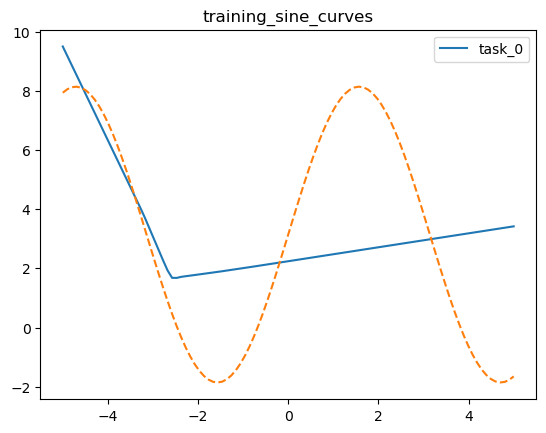

In [46]:
reml.train()
path = f"meta_{config['sb3_model']}_{datetime.datetime.now().strftime('%H-%M')}"
reml.model.save(path)

### meta analysis

#### speed of training test

In [ ]:
# get loss for meta trained network per step
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
meta_lossperstep_bytask = reml.evaluate_loss_curves()

# get loss for vanilla network per step
vanilla_lossperstep_bytask = {}
for task, x, y in zip(tasks, tasks_data, tasks_targets):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    vanilla_lossperstep_bytask[task] = []
    for epoch in range(100):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
        vanilla_lossperstep_bytask[task].append(loss)


In [ ]:
for i, (x, y) in enumerate(zip(tasks_data, tasks_targets)):
    task = tasks[i]
    vanilla_label = f'Vanilla network: Task {i+1}' 
    meta_label = f'Meta-trained network: Task {i+1}' 
    meta_loss_vals = [val.detach().numpy() for val in meta_lossperstep_bytask[task]]
    vanilla_loss_vals = [val.detach().numpy() for val in vanilla_lossperstep_bytask[task]]
    plt.plot(range(100), vanilla_loss_vals, label=vanilla_label)
    plt.plot(range(100), meta_loss_vals, label=meta_label)
    plt.xlabel('Timestep')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()


#### few shot learning tests

k=5

In [ ]:
# unseen task
# choose 5 and 10 datapoints on it, K = 5, K = 10
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

# network still recieves the same 100 x values {-5, ..., 5}
# the difference is that a target value is only provided for 5 or 10 of these 100 values
# start by generating the 'pre-update' curve 
# next pass k datapoints and do 1 gradient update step to get the curve
# next do 9 more gradient update steps (total 10) to get next curve
# plot 'pre-update', '1 grad step', '10 grad steps' curves together with the 'k_pairs' data points

In [ ]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')

k=10

In [ ]:
k = 10
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

In [ ]:
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=10')

## episodic learning 

In [ ]:
config['episodic'] = True
config

In [ ]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
eval_task = random.choice(list(tasks))
training_tasks = list(set(tasks) - {eval_task})
pool = LayerPool(layers=layers) if config['pretrain'] else LayerPool(layers=None)
reml = REML(layer_pool=pool, tasks=training_tasks)

In [ ]:
reml.train()
path = f"meta_episodic_{config['sb3_model']}_{datetime.datetime.now().strftime('%H-%M')}"
reml.model.save(path)

In [ ]:
# get loss for meta trained network per step
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
meta_lossperstep_bytask = reml.evaluate_loss_curves()

# get loss for vanilla network per step
vanilla_lossperstep_bytask = {}
for task, x, y in zip(tasks, tasks_data, tasks_targets):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    model.train()
    vanilla_lossperstep_bytask[task] = []
    for epoch in range(100):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
        vanilla_lossperstep_bytask[task].append(loss)


In [ ]:
for i, (x, y) in enumerate(zip(tasks_data, tasks_targets)):
    task = tasks[i]
    vanilla_label = f'Vanilla network: Task {i+1}' 
    meta_label = f'Meta-trained network: Task {i+1}' 
    meta_loss_vals = [val.detach().numpy() for val in meta_lossperstep_bytask[task]]
    vanilla_loss_vals = [val.detach().numpy() for val in vanilla_lossperstep_bytask[task]]
    plt.plot(range(100), vanilla_loss_vals, label=vanilla_label)
    plt.plot(range(100), meta_loss_vals, label=meta_label)
    plt.xlabel('Timestep')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()


#### k=5

In [ ]:
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

In [ ]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')